Auto Regressive Model `AR Model` is a linera model where current period values are a sum of past values multiplied by a numeric factor (The numeric factor should be between -1 and +1 to maintain stability). It learns from `past values`.

Current value = [Past value * Numeric Factor] + Constant + current residual.

`AR(1) Model` uses only one past value i.e., the past 1 value.

`AR(2) Model` uses previous value and previous to previous value i.e., past 2 values.

Importing and preparing the time series data for modelling. 


In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
df = pd.read_csv("Index2018.csv")
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")
df.set_index('date',inplace=True)
df = df.asfreq('b')

for col in df.columns.to_list():
    df[col] = df[col].fillna(method='ffill')
    df[col] = df[col].fillna(method='bfill')

df.isna().sum(axis=0) 

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [6]:
df.head(5)

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


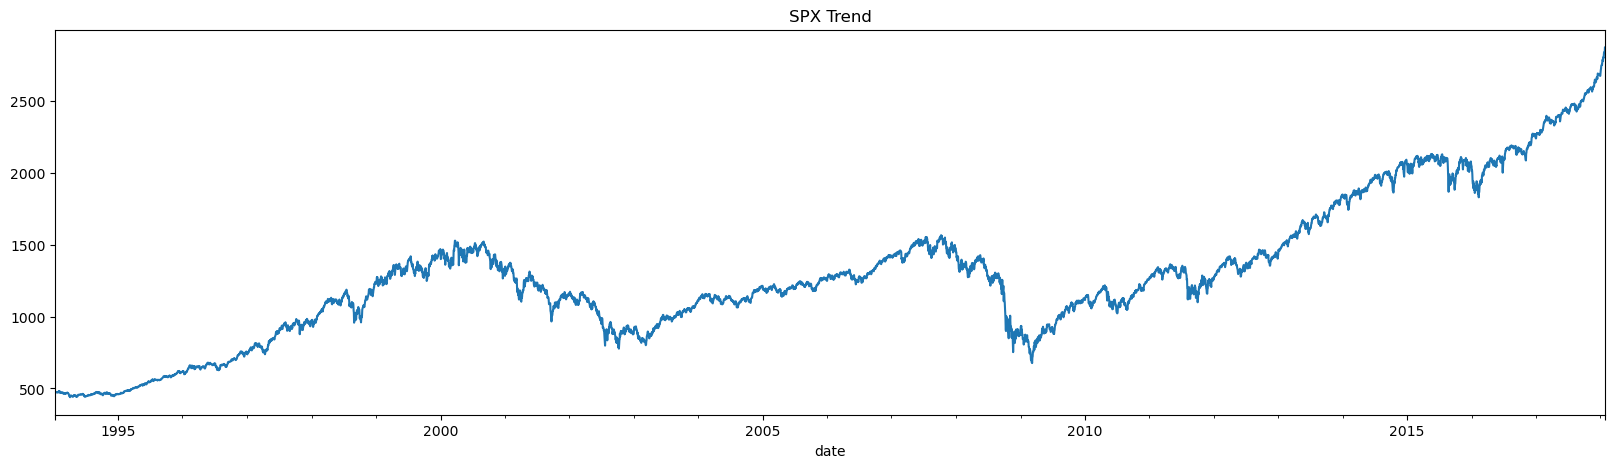

In [107]:
import matplotlib.pyplot as plt

df['spx'].plot(figsize=(20,5))
plt.title("SPX Trend")
plt.show()

`AR Models` work well only with stationary data. Doing a stationarity test on `spx`

In [63]:
from statsmodels.tsa.stattools import adfuller

if adfuller(df['spx'])[1]<0.05:
    print("Stationary")
else:
    print("Non-Stationary")

Non-Stationary


As the series is `non-stationary`, the `AR Model` will `not perform` well. The series needs to be transformed into `stationary` series before fitting the model. But, we will continue to fit with non-stationary to understand the issues.

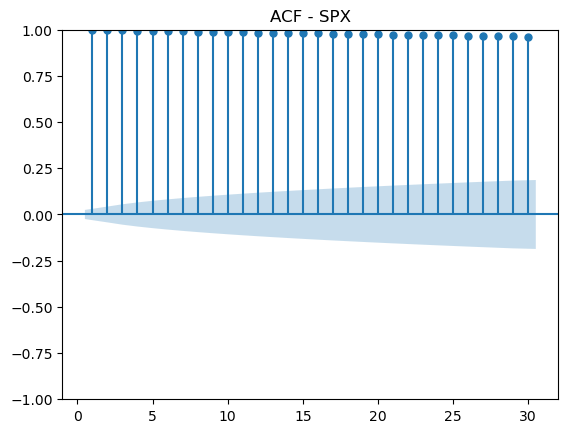

In [10]:
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt

sgt.plot_acf(df['spx'],lags = 30, zero=False ,title= 'ACF - SPX') # zero=False avoids plotting the zeroth lag
plt.show()

The above `ACF` plot shows that the effects barely deteriorate over several lags. 

A `slow decaying ACF` could imply `Non-stationarity` which could be handled by transformations like differencing.

As the ACF shows both direct and indirect effects, let's check `PACF` plot. 


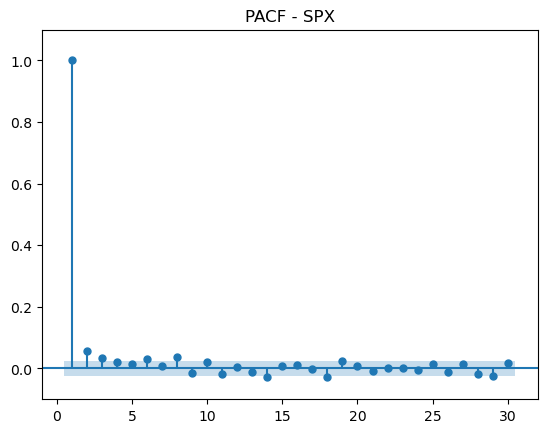

In [14]:
sgt.plot_pacf(df['spx'],lags = 30, zero=False,method=('ols'),title= 'PACF - SPX') # zero=False avoids plotting the zeroth lag
plt.ylim(-0.1,1.1)
plt.show()

As the `PACF` shows that the direct effect of only the first lag is highly significant, will try `AR(1) Model` 

Splitting the data into train and test set

In [21]:
test_size = int(len(df)*0.8)

df_train = df.iloc[:test_size]
df_test = df.iloc[test_size:]

In [22]:
from statsmodels.tsa.arima.model import ARIMA

ar1 = ARIMA(df_train['spx'],order=(1,0,0))  
ar1_results = ar1.fit()
ar1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 5021
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -20097.439
Date:                Sun, 31 Aug 2025   AIC                          40200.879
Time:                        22:22:20   BIC                          40220.443
Sample:                    01-07-1994   HQIC                         40207.734
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6133    165.184      6.608      0.000     767.858    1415.369
ar.L1          0.9992      0.001   1695.377      0.000       0.998       1.000
sigma2       175.2480      1.771     98.978      0.000     171.778     178.718
===================================================================================
Ljung-Box (L1) (Q):                  24.60   Jarque-Bera (JB):              7473.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

order=(p,d,q) where p is the order of AR model, q is the order of MA model, d is the differencing order

In the summary, `ar.L1` is the coefficient of `auto regressive value` in the AR1 model. As the p-value is close to 0, the coefficient ar.L1 is significantly different from zero and can be used for model.

The value of `ar.L1` is very close to 1 (i.e, 0.9992) which was shown in the PACF plot.

As all the coefficients (`ar.L1` and `const`) are significantly different from 0, we should cehck if a complex model yields coefficients that are all significant

In [23]:
ar2 = ARIMA(df_train['spx'],order=(2,0,0))  
ar2_results = ar2.fit()
ar2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 5021
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -20085.289
Date:                Sun, 31 Aug 2025   AIC                          40178.578
Time:                        22:43:18   BIC                          40204.664
Sample:                    01-07-1994   HQIC                         40187.719
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6076    223.345      4.888      0.000     653.859    1529.356
ar.L1          0.9300      0.009     99.031      0.000       0.912       0.948
ar.L2          0.0694      0.009      7.405      0.000       0.051       0.088
sigma2       174.3965      1.768     98.654      0.000     170.932     177.861
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              7475.27
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As all the coefficients (`ar.L1`, `ar.L2`  and `const`) are significantly different from 0, let's try a more complex model as there could be more pattern left uncaptured.

In [24]:
ar3 = ARIMA(df_train['spx'],order=(3,0,0))  
ar3_results = ar3.fit()
ar3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 5021
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -20083.003
Date:                Sun, 31 Aug 2025   AIC                          40176.005
Time:                        22:59:09   BIC                          40208.612
Sample:                    01-07-1994   HQIC                         40187.431
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6519    119.496      9.135      0.000     857.444    1325.860
ar.L1          0.9271      0.009     97.886      0.000       0.909       0.946
ar.L2          0.0376      0.012      3.227      0.001       0.015       0.060
ar.L3          0.0342      0.008      4.437      0.000       0.019       0.049
sigma2       174.1643      1.799     96.828      0.000     170.639     177.690
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7224.32
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Again, as all the coefficients (`ar.L1`, `ar.L2`, `ar.L3`  and `const`) are significantly different from 0, let's try a more complex model.

In [25]:
ar4 = ARIMA(df_train['spx'],order=(4,0,0))  
ar4_results = ar4.fit()
ar4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 5021
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -20081.936
Date:                Sun, 31 Aug 2025   AIC                          40175.873
Time:                        23:05:27   BIC                          40215.001
Sample:                    01-07-1994   HQIC                         40189.584
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6519    121.400      8.992      0.000     853.713    1329.591
ar.L1          0.9264      0.009     97.776      0.000       0.908       0.945
ar.L2          0.0368      0.012      3.147      0.002       0.014       0.060
ar.L3          0.0148      0.012      1.272      0.203      -0.008       0.038
ar.L4          0.0208      0.009      2.249      0.025       0.003       0.039
sigma2       174.1229      1.800     96.734      0.000     170.595     177.651
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7229.16
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As the coefficient for all coefficients are not significant (`ar.L3` is not significantly different from zero), may be AR4 is not worth the complexity. THis is in line with the `PACF` plot where first 3 lags showed significant correlation. So, `PACF` plot can be used to determine the order of AR models. Let's see what if we continue increasing the complexity (order) though we should have stopped.

In [26]:
ar5 = ARIMA(df_train['spx'],order=(5,0,0))  
ar5_results = ar5.fit()
ar5_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 5021
Model:                 ARIMA(5, 0, 0)   Log Likelihood              -20081.852
Date:                Sun, 31 Aug 2025   AIC                          40177.704
Time:                        23:28:08   BIC                          40223.353
Sample:                    01-07-1994   HQIC                         40193.700
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6519    122.005      8.948      0.000     852.526    1330.778
ar.L1          0.9263      0.009     97.701      0.000       0.908       0.945
ar.L2          0.0367      0.012      3.138      0.002       0.014       0.060
ar.L3          0.0146      0.012      1.250      0.211      -0.008       0.038
ar.L4          0.0150      0.012      1.219      0.223      -0.009       0.039
ar.L5          0.0062      0.009      0.711      0.477      -0.011       0.023
sigma2       174.1493      1.801     96.713      0.000     170.620     177.679
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7233.86
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
ar6 = ARIMA(df_train['spx'],order=(6,0,0))  
ar6_results = ar6.fit()

ar7 = ARIMA(df_train['spx'],order=(7,0,0))  
ar7_results = ar7.fit()

ar8 = ARIMA(df_train['spx'],order=(8,0,0))  
ar8_results = ar8.fit()

ar9 = ARIMA(df_train['spx'],order=(9,0,0))  
ar9_results = ar9.fit()

THe coefficients `ar.L3`, `ar.L4` and `ar.L5` are all insignificant here. Let us compare the models using Log Likelihood Ratio Test (LLR Test) because these are hierarchical models (i.e., simpler model is aa part of complex model)

In [41]:
def LLR_test(model_simple,model_complex,dof=1):
    from scipy.stats import chi2
    L1 = model_simple.fit().llf
    L2 = model_complex.fit().llf
    LLR = (2*(L2-L1))
    p = chi2.sf(LLR,dof).round(3)
    return float(p)

In [42]:
LLR_test(ar1,ar2,1)

0.0

As the test is significant, the complex model is worth the comlexity as it captures the data significantly better.

In [44]:
LLR_test(ar2,ar3,1)

0.032

Again, ar3 is significantly better than ar2 as the p-value is within 0.05

In [45]:
LLR_test(ar3,ar4,1)

0.144

ar4 doesn't significantly improve the model performance given the higher complexity. So, we should opt for a simpler model.

But the `PACF` plot shows 8th lag being significant. So try upto AR8 and see if it gives significantly better results.

In [51]:
LLR_test(ar4,ar5,1)

0.681

In [50]:
LLR_test(ar5,ar6,1)

0.085

In [53]:
LLR_test(ar6,ar7,1)

0.116

In [54]:
LLR_test(ar7,ar8,1)

0.005

In [58]:
LLR_test(ar8,ar9,1)

0.144

Let's look ar the summary of ar8 that showed significance

In [56]:
ar8_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 5021
Model:                 ARIMA(8, 0, 0)   Log Likelihood              -20075.114
Date:                Sun, 31 Aug 2025   AIC                          40170.229
Time:                        23:56:36   BIC                          40235.443
Sample:                    01-07-1994   HQIC                         40193.081
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1091.6519    127.586      8.556      0.000     841.589    1341.715
ar.L1          0.9246      0.010     96.975      0.000       0.906       0.943
ar.L2          0.0366      0.012      3.125      0.002       0.014       0.060
ar.L3          0.0146      0.012      1.241      0.215      -0.008       0.038
ar.L4          0.0133      0.012      1.065      0.287      -0.011       0.038
ar.L5         -0.0178      0.012     -1.458      0.145      -0.042       0.006
ar.L6          0.0022      0.011      0.201      0.840      -0.019       0.024
ar.L7         -0.0149      0.012     -1.293      0.196      -0.037       0.008
ar.L8          0.0403      0.008      4.740      0.000       0.024       0.057
sigma2       173.7773      1.818     95.604      0.000     170.215     177.340
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7121.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As ar8 model has several coefficients that are insignificant while it is significantly better than ar7, check ar8 against a simpler model (within the hierarchy). The last simpler model which had all of its coefficients significant is ar3

In [59]:
LLR_test(ar3,ar8,5)

0.008

As the model ar8 shows significantly better improvement, we can stick to ar8 as our final model. This decision is also because of the insignificant correlation shown in `PACF` for higher lags.

**Important Note:** The model `ar8` has come out as better model that ar3 through LLR Test though there are insignificant coefficients. This usually results if we are trying to predict `Non-Stationary Data` with AR Model.

One way to create stationary series is by calculating percentage change between current and previous time-period and using this percentage change instead of actual values as series. 


In [65]:
df['returns'] = df['spx'].pct_change(1).mul(100)
df = df.iloc[1:]   # removing the NA resulting from percent change calculation
df.head(3)

,spx,dax,ftse,nikkei,returns
date,,,,,
1994-01-10,475.27,2225.00,3440.58,18443.44,1.142796
1994-01-11,474.13,2228.10,3413.77,18485.25,-0.239864
1994-01-12,474.17,2182.06,3372.02,18793.88,0.008437


Checking `returns` for stationarity

In [66]:
from statsmodels.tsa.stattools import adfuller

if adfuller(df['returns'])[1]<0.05:
    print("Stationary")
else:
    print("Non-Stationary")

Stationary




Making a new train test split to include `returns`

In [72]:
test_size = int(len(df)*0.8)

df_train = df.iloc[:test_size]
df_test = df.iloc[test_size:]

Great, let us fo `ACF` and `PACF` plots to check the significant lags that can be used for modelling

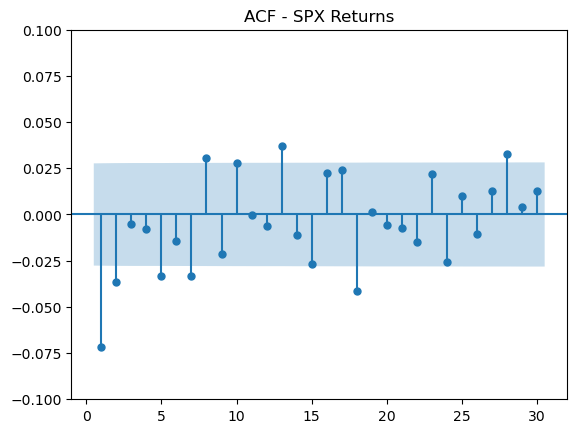

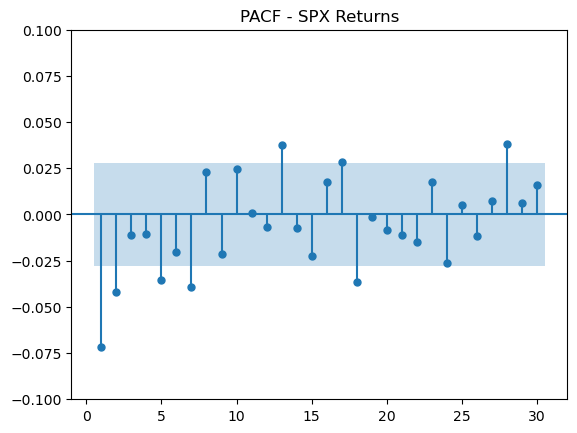

In [100]:
sgt.plot_acf(df_train['returns'],lags = 30, zero=False ,title= 'ACF - SPX Returns') # zero=False avoids plotting the zeroth lag
plt.ylim(-0.1,0.1)
plt.show()

sgt.plot_pacf(df_train['returns'],lags = 30, zero=False,method=('ols'),title= 'PACF - SPX Returns') # zero=False avoids plotting the zeroth lag
plt.ylim(-0.1,0.1)
plt.show()

Only the first few lagged correlations are significant but they are mainly negative(negatively correlated) indicating that consecutive returns move in oppisite directions (indicating natural adjustments within market). Around 10 lags are significant pased on `PACF`.

In [73]:
ar1_ret = ARIMA(df_train['returns'],order=(1,0,0))  
ar1_ret_results = ar1_ret.fit()
ar1_ret_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -8067.541
Date:                Mon, 01 Sep 2025   AIC                          16141.081
Time:                        12:23:28   BIC                          16160.645
Sample:                    01-10-1994   HQIC                         16147.937
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.016      1.915      0.055      -0.001       0.063
ar.L1         -0.0719      0.008     -8.514      0.000      -0.088      -0.055
sigma2         1.4568      0.013    114.005      0.000       1.432       1.482
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             14951.82
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Note**: if a simple model shows insignificant coefficients, it could be that the higher lags(not accountd in model) affect the lags accounted in the model. Recommendation is that we try a more complex model 

In [74]:
ar2_ret = ARIMA(df_train['returns'],order=(2,0,0))  
ar2_ret_results = ar2_ret.fit()

ar3_ret = ARIMA(df_train['returns'],order=(3,0,0))  
ar3_ret_results = ar3_ret.fit()

ar4_ret = ARIMA(df_train['returns'],order=(4,0,0))  
ar4_ret_results = ar4_ret.fit()

ar5_ret = ARIMA(df_train['returns'],order=(5,0,0))  
ar5_ret_results = ar5_ret.fit()

ar6_ret = ARIMA(df_train['returns'],order=(6,0,0))  
ar6_ret_results = ar6_ret.fit()

ar7_ret = ARIMA(df_train['returns'],order=(7,0,0))  
ar7_ret_results = ar7_ret.fit()

ar8_ret = ARIMA(df_train['returns'],order=(8,0,0))  
ar8_ret_results = ar8_ret.fit()

ar9_ret = ARIMA(df_train['returns'],order=(9,0,0))  
ar9_ret_results = ar9_ret.fit()

ar10_ret = ARIMA(df_train['returns'],order=(10,0,0))  
ar10_ret_results = ar10_ret.fit()

Basis `LLR Test`, let us compare the models

In [83]:
for i in range(1,10):
    if LLR_test(globals()['ar'+str(i)+'_ret'],globals()['ar'+str(i+1)+'_ret'],1) <= 0.05:
        print('ar'+str(i+1)+'_ret is significant vs ar'+str(i)+'_ret')

ar2_ret is significant vs ar1_ret
ar5_ret is significant vs ar4_ret
ar7_ret is significant vs ar6_ret


Matching the `PACF` results, only lags 2, 5, 7 are significant.

Let us compare betwen the significant models

In [86]:
if LLR_test(ar5_ret,ar7_ret,7-5) <= 0.05:
    print("Is significant")

Is significant


In [89]:
if LLR_test(ar2_ret,ar7_ret,7-2) <= 0.05:
    print("Is significant")

Is significant


As `ar7_ret` is significant compared to all simpler models, let us examine the coefficients

In [91]:
ar7_ret_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -8054.618
Date:                Mon, 01 Sep 2025   AIC                          16127.236
Time:                        13:17:32   BIC                          16185.926
Sample:                    01-10-1994   HQIC                         16147.802
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.015      2.136      0.033       0.003       0.060
ar.L1         -0.0773      0.009     -9.016      0.000      -0.094      -0.061
ar.L2         -0.0451      0.007     -6.518      0.000      -0.059      -0.032
ar.L3         -0.0140      0.009     -1.627      0.104      -0.031       0.003
ar.L4         -0.0147      0.008     -1.857      0.063      -0.030       0.001
ar.L5         -0.0386      0.007     -5.261      0.000      -0.053      -0.024
ar.L6         -0.0232      0.008     -3.051      0.002      -0.038      -0.008
ar.L7         -0.0389      0.007     -5.217      0.000      -0.054      -0.024
sigma2         1.4494      0.014    105.905      0.000       1.423       1.476
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13333.85
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see most of the coefficients are significant (except `ar.L3`). We can choose ar7_ret as the model.

Though `Normalizing` the data is `not strictly necessary` in time series modelling, it can help handle sudden peaks in data much better.

As a final step in this iteration, let's `Aanalyze the Residuals` to check if there are any pattern left.  
Taking the resudials from the fitted model into the dataframe for further analysis.

In [94]:
df_train['ar7_ret_residuals'] = ar7_ret_results.resid

Check the mean and variance of the residuals, ideally `mean` should be closer to 0 and `variance` should be low

In [96]:
print(df_train['ar7_ret_residuals'].mean())
print(df_train['ar7_ret_residuals'].var())

4.4639617415521376e-05
1.4496606681285904


The above results seem fine. 

Let us see if the residuals of model `ar8` that was trained on `non-stationary` data.



In [110]:
df_train['ar8_residuals'] = ar8_results.resid
print(df_train['ar8_residuals'].mean())
print(df_train['ar8_residuals'].var())

0.2674047360877034
173.5059934702072


Though ar8 was a fairly complex model, we see much higher mean and variance compared to the model trained with stationary data.

Let us see if the residuals resemble `white noise`. We can start with `stationarity` test

In [97]:
if adfuller(df_train['ar7_ret_residuals'])[1]<0.05:
    print("Stationary")
else:
    print("Non-Stationary")

Stationary


One of the assumptions of white noise is that it should have `no autocorrelation`

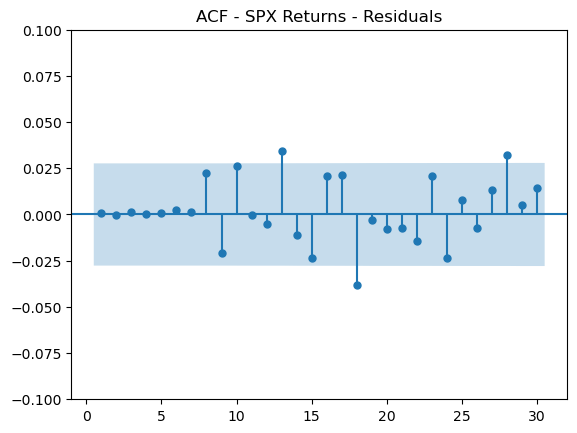

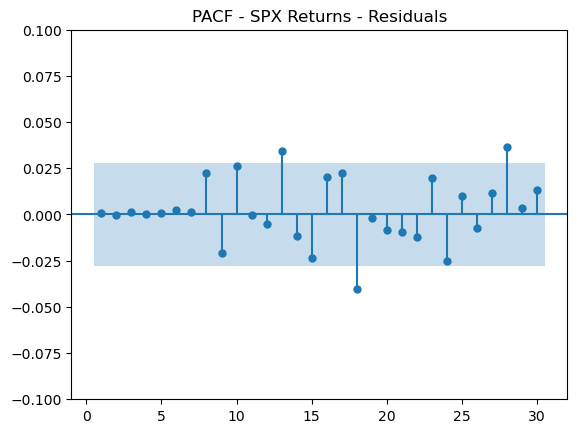

In [102]:
sgt.plot_acf(df_train['ar7_ret_residuals'],lags = 30, zero=False ,title= 'ACF - SPX Returns - Residuals') # zero=False avoids plotting the zeroth lag
plt.ylim(-0.1,0.1)
plt.show()

sgt.plot_pacf(df_train['ar7_ret_residuals'],lags = 30, zero=False,method=('ols'),title= 'PACF - SPX Returns - Residuals') # zero=False avoids plotting the zeroth lag
plt.ylim(-0.1,0.1)
plt.show()

As we see some higher lags show significant correlation, let us `examine` the residual timeseries `manually` for any pattern (trend).

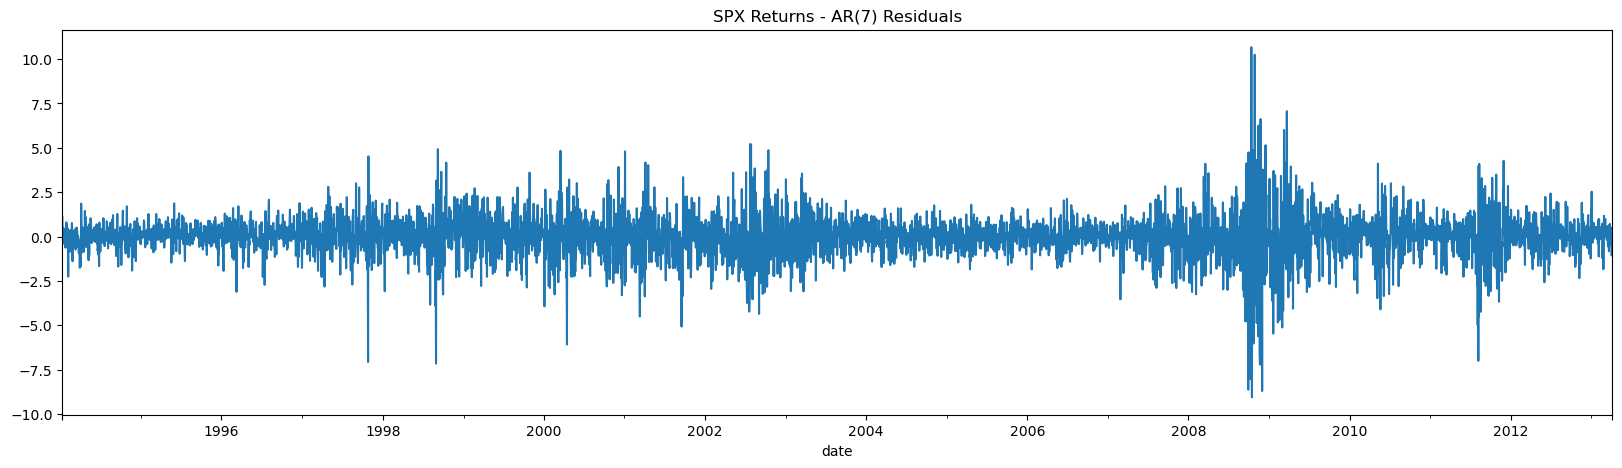

In [112]:
df_train['ar7_ret_residuals'].plot(figsize=(20,5))
plt.title("SPX Returns - AR(7) Residuals")
plt.show()

We don't see any trend or pattern except for few peaks where external factors are probably not well captured by the model.